In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

from itertools import combinations
from collections import Counter

In [2]:
#file_path = './data/hakaton.csv'

In [3]:
df = pd.read_csv('hakaton.csv',sep=';')

In [4]:
seasons = {'winter': [1,2,12], 
           'spring': [3,4,5],
           'summer': [6,7,8],
           'autumn': [9,10,11]}

hours = {1: [6,7,8,9,10],
         2: [11,12,13,14,15],
         3: [16,17,18,19,20],
         4: [21,22,23,0,1]}

In [5]:
def preprocessing_df(df):
    df['create_datetime'] = pd.to_datetime(df['create_datetime'])
    df['order_day'] = df['create_datetime'].dt.day
    df['order_hour'] = df['create_datetime'].dt.hour
    df['order_weekday'] = df['create_datetime'].dt.weekday
    df['order_month'] = df['create_datetime'].dt.month
    df['order_year'] = df['create_datetime'].dt.year
    df['day_of_week_name'] = df['create_datetime'].dt.day_name()
    df['order_week'] = df['create_datetime'].dt.isocalendar().week
    days_translation = {
        'Monday': 'Понедельник',
        'Tuesday': 'Вторник',
        'Wednesday': 'Среда',
        'Thursday': 'Четверг',
        'Friday': 'Пятница',
        'Saturday': 'Суббота',
        'Sunday': 'Воскресенье'
    }
    
    df['day_of_week_name'] = df['day_of_week_name'].map(days_translation)
    def categorize_hour(hour):
        for category, hour_list in hours.items():
            if hour in hour_list:
                return category
        return None  # на случай, если час не попадает в список

    df['hour_category'] = df['order_hour'].apply(categorize_hour)
    return df

In [6]:
def buy_together(df):
    df_grouped = df.groupby(['order_id','customer_id'])['entity_id'].agg(list).reset_index()
    df_together = df_grouped[df_grouped['entity_id'].apply(len) >= 0]
    return df_together

In [7]:
def popular_products_of_the_day(df, day_date=None, month_date=None, year_date=None, flag=False):
    """
    Выявление товаров на скидку в течение дня с учетом временного интервала
    """
    if day_date and month_date and year_date:
        df = df[(df['order_day'] == day_date) & (df['order_month'] == month_date) & (df['order_year'] == year_date)]

    df = df.groupby(['hour_category', 'entity_id'])['hour_category'].size().reset_index(name='count')
    df = df.sort_values(by='count', ascending=not flag)
    df = df[df['count'] >= 1]
    
    selected_entities = set()
    new_df = pd.DataFrame(columns=df.columns)

    for i in range(1, 5):
        hour_group = df[(df['hour_category'] == i) & (~df['entity_id'].isin(selected_entities))]
        if not hour_group.empty:
            median_index = hour_group.iloc[int(np.median(range(len(hour_group))))].name
            new_df.loc[len(new_df)] = df.loc[median_index]
            selected_entities.add(df.loc[median_index, 'entity_id'])

    return new_df

In [8]:
def visit_frequency(df, customer_id=None):
    if customer_id: 
        df = df[df['customer_id'] == customer_id]

    day_order = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
    df.loc[:, 'day_of_week_name'] = pd.Categorical(df['day_of_week_name'], categories=day_order, ordered=True)
    df_week = df.groupby('day_of_week_name')['order_id'].size().reset_index(name='count')
    df_week = df_week.sort_values(by='day_of_week_name', key=lambda x: x.map({day: idx for idx, day in enumerate(day_order)}))
    
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    sns.barplot(data=df_week, x='day_of_week_name', y='count', hue='count', palette='Set2', ax=ax1)
    ax1.set_title(f'Диаграмма количества посещений в разные дни для клиента {customer_id}')
    ax1.set_xlabel('День недели')
    ax1.set_ylabel('Количество')
    ax1.legend(title='Количество', bbox_to_anchor=(1, 1))
    
    df_hours = df.groupby('order_hour')['order_id'].size().reset_index(name='count').sort_values(by='count', ascending=False)
    
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    sns.barplot(data=df_hours, x='order_hour', y='count', hue='count', palette='Set2', ax=ax2)
    ax2.set_title(f'Диаграмма посещений в разные часы для клиента {customer_id}')
    ax2.set_xlabel('Время')
    ax2.set_ylabel('Количество')
    ax2.legend(title='Количество', bbox_to_anchor=(1, 1))

    return fig1, fig2, df_week, df_hours

In [9]:
def find_most_frequent_pairs(df,customer_id = None):
    """
    Функция находит наиболее часто покупаемые товары вместе.
    
    :param df: DataFrame с колонками 'order_id' и 'entity_id' (где entity_id - список товаров)
    :return: DataFrame с парами товаров и их частотой
    """
    if customer_id:
        find_df = df[df['customer_id'] == customer_id]
    else:
        find_df = df
        
    def generate_item_pairs(item_list):
        return list(combinations(sorted(item_list), 2))

    all_pairs = []
    for item_list in find_df['entity_id']:
        all_pairs.extend(generate_item_pairs(item_list))
        
    pair_counts = Counter(all_pairs)
    pair_counts_df = pd.DataFrame(pair_counts.items(), columns=['pair', 'count'])
    pair_counts_df = pair_counts_df[pair_counts_df['pair'].apply(lambda x: x[0] != x[1])]
    pair_counts_df_sorted = pair_counts_df.sort_values(by='count', ascending=False).reset_index(drop=True)
    pair_counts_df_sorted = pair_counts_df_sorted[pair_counts_df_sorted['count'] >= 2]
    
    if len(pair_counts_df_sorted) < 3:
        return find_most_frequent_pairs(df) 

    return pair_counts_df_sorted

In [10]:
def find_frequent_pairs_with_entity(df, entity_id):
    """
    Функция находит наиболее часто встречающиеся пары товаров с указанным entity_id,
    и возвращает только вторые товары в этих парах.
    
    :param df: DataFrame с колонками 'pair' и 'count' (где 'pair' - пара товаров, 'count' - частота)
    :param entity_id: Идентификатор товара, с которым ищем часто встречающиеся пары
    :return: DataFrame с вторыми товарами в парах и их частотой
    """
    filtered_df = df[df['pair'].apply(lambda x: entity_id in x)].copy()
    filtered_df['second_item'] = filtered_df['pair'].apply(lambda x: x[1] if x[0] == entity_id else x[0])
    filtered_df_sorted = filtered_df[['second_item', 'count']].sort_values(by='count', ascending=False).reset_index(drop=True)

    median_index = np.median(filtered_df_sorted.index)
    indices_near_median = filtered_df_sorted.index[(filtered_df_sorted.index >= median_index - 1) & (filtered_df_sorted.index <= median_index + 1)]
    filtered_df_sorted = filtered_df_sorted.loc[indices_near_median]
    
    return filtered_df_sorted[:3].loc[:,'second_item'].values, filtered_df_sorted

In [11]:
def metrics_client(df, customer_id, entitys_id):
    offered_products_set = set()
    df_offered_products_list = []

    for i in entitys_id:
        offered_products, df_offered_products = find_frequent_pairs_with_entity(most_frequent_pairs, i)
        offered_products_set.update(offered_products)
        df_offered_products_list.append(df_offered_products)


    combined_df_offered_products = pd.concat(df_offered_products_list, ignore_index=True)

    offered_products_arr = [product for product in offered_products_set if product not in entitys_id]
    
    return offered_products_arr, combined_df_offered_products

In [12]:
def stat_of_the_day(df, start_d, start_m, start_y, end_d, end_m, end_y):
    # Преобразование строки в дату
    start = datetime(start_y, start_m, start_d)
    end = datetime(end_y, end_m, end_d)

    # Преобразуем create_datetime в формат только с датой (без времени)
    df['create_date'] = pd.to_datetime(df['create_datetime']).dt.date

    # Фильтруем данные по заданному диапазону дат
    period = df.loc[(df['create_date'] >= start.date()) & (df['create_date'] <= end.date())]

    # Получаем количество дней в периоде
    col_day = (end - start).days

    # Создадим словарь для хранения статистики по дням
    days_products = {}

    # Для каждого дня в периоде находим покупки
    for single_date in pd.date_range(start, end):
        day_products = period.loc[period['create_date'] == single_date.date()]\
            .groupby('entity_id')['entity_id'].count().sort_values(ascending=False).head(3)
        days_products[single_date.date()] = day_products

    # Построение столбчатой диаграммы
    fig, ax = plt.subplots(figsize=(15, 8))
    for date, products in days_products.items():
        if not products.empty:
            product_names = [f'Товар {idx}' for idx in products.index]
            ax.bar([f'{date} - {name}' for name in product_names], products.values)

    ax.set_title(f'Топ-3 товаров за период с {start.date()} по {end.date()}')
    ax.set_xlabel('Дата - Товар')
    ax.set_ylabel('Количество продаж')
    plt.xticks(rotation=90)
    plt.close(fig)
    
    return fig


In [13]:
def stat_of_the_year(df, year):
    # Преобразуем create_datetime в формат только с датой (без времени)
    df['create_date'] = pd.to_datetime(df['create_datetime']).dt.date

    # Фильтруем данные по году
    df_year = df[df['create_date'].apply(lambda x: x.year == year)]

    # Создадим список для хранения статистики по месяцам
    monthly_products = {month: [] for month in range(1, 13)}

    # Группируем по месяцам и собираем товары для каждого месяца
    for month in range(1, 13):
        monthly_data = df_year[df_year['create_date'].apply(lambda x: x.month == month)]
        monthly_products[month] = monthly_data.groupby('entity_id')['entity_id'].count().sort_values(ascending=False).head(3)

    # Подготовка данных для визуализации
    month_names = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь", "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]

    # Создание объекта фигуры
    fig, ax = plt.subplots(figsize=(15, 8))

    # Для каждого месяца строим данные на графике
    for month in range(1, 13):
        top_products = monthly_products[month]
        if not top_products.empty:
            product_names = [f'Товар {idx}' for idx in top_products.index]
            ax.bar([f'{month_names[month-1]} - {name}' for name in product_names], top_products.values)

    # Настройки графика
    ax.set_title(f'Топ-3 товаров по месяцам в {year} году')
    ax.set_xlabel('Месяц - Товар')
    ax.set_ylabel('Количество продаж')
    plt.xticks(rotation=90)
    plt.close(fig)
    
    # Возвращаем объект фигуры, не рисуем её
    return fig


In [14]:
def metrics_client(df,customer_id,entitys_id):
    offered_products_set = set()
    for i in entitys_id:
        offered_products, df_offered_products = find_frequent_pairs_with_entity(most_frequent_pairs, i)
        offered_products_set.update(offered_products)
    offered_products_arr = [product for product in offered_products_set if product not in entitys_id]
    #что чаще берут в диаграмме
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    ax2.pie(df_offered_products['count'], labels=df_offered_products['second_item'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    ax2.set_title(f"Какие товары чаще берут с тем, что взял клиент {customer_id}")
    ax2.legend(title='Товары',bbox_to_anchor=(1, 1))
    return offered_products_arr, df_offered_products, fig2

In [15]:
#Предобработка, должна выполнятся по загрузке файла
df = preprocessing_df(df) # Обработка датафрейма
df_buy_together = buy_together(df) # Объединение заказов
most_frequent_pairs_customer = find_most_frequent_pairs(df_buy_together, 9172) #Передача id клиента, выдача часто сочетаемых товаров у клиента
most_frequent_pairs = find_most_frequent_pairs(df_buy_together) #Часто сочетаемые товары

- stat_of_the_year - возвращает график топ 3 товара по месяцам за год (принимает датафрейм и год)
- stat_of_the_day - возвращает график топ 3 товара за промежуток (принимает датафрейм, дату начала и дату конца отсчёта (день, месяц, год)) 
- metrics_client - вовзращает информацию о том, какие товары часто берут с тем, что взял клиент. На какие товары можно дать скидку, при условии что этого товара нет в корзине. (рекомендуем взять эти товары)
    - 1-ый параметр - датафрейм с часто сочетаемыми товарами (можно передать часто сочетаемые товары клиента)
    - 2-ой параметр - id клиента
    - 3-ий параметр  - корзина покупок
- visit_frequency - возвращает диаграмму количества посещений определенного клиента в разные дни недели, также возвращает посещение по часам (принимает датафрейм и id клиента)


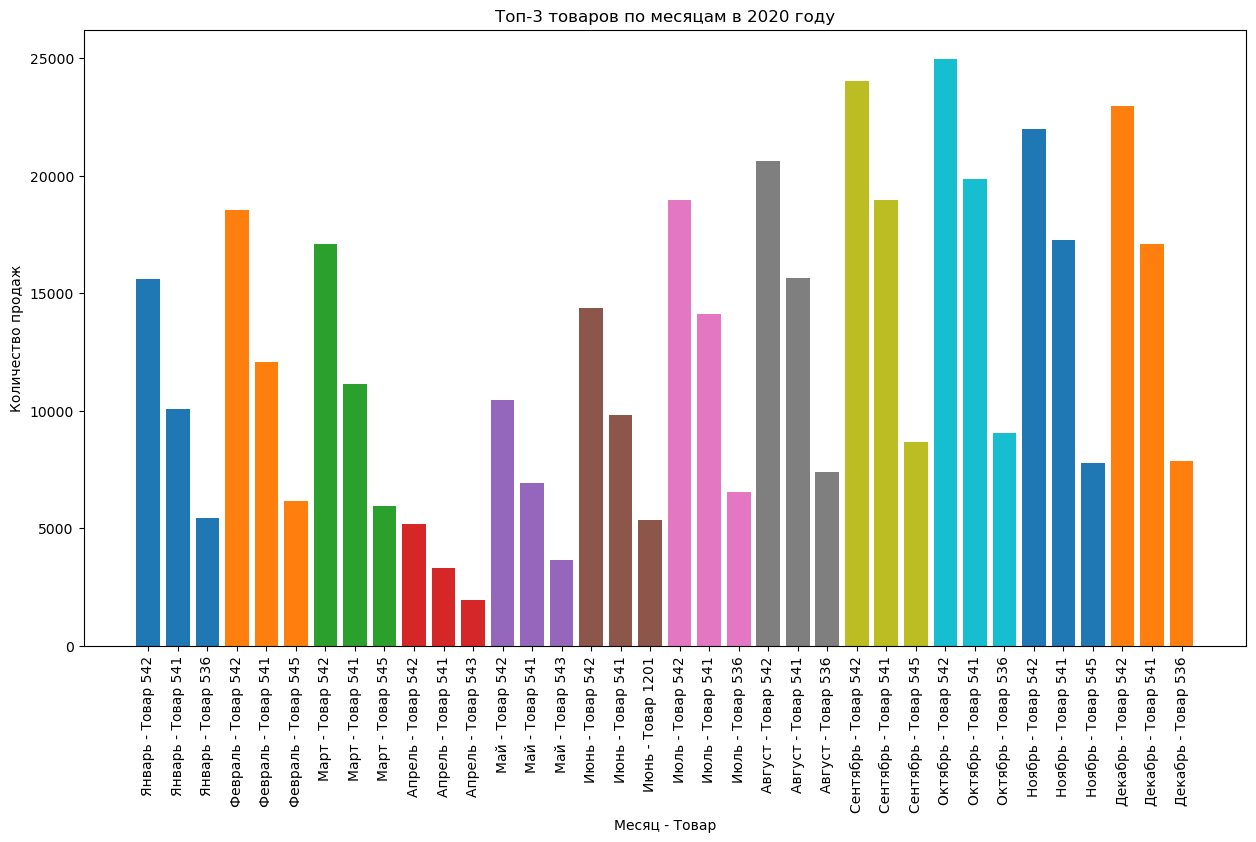

In [16]:
stat_of_the_year(df,2020)

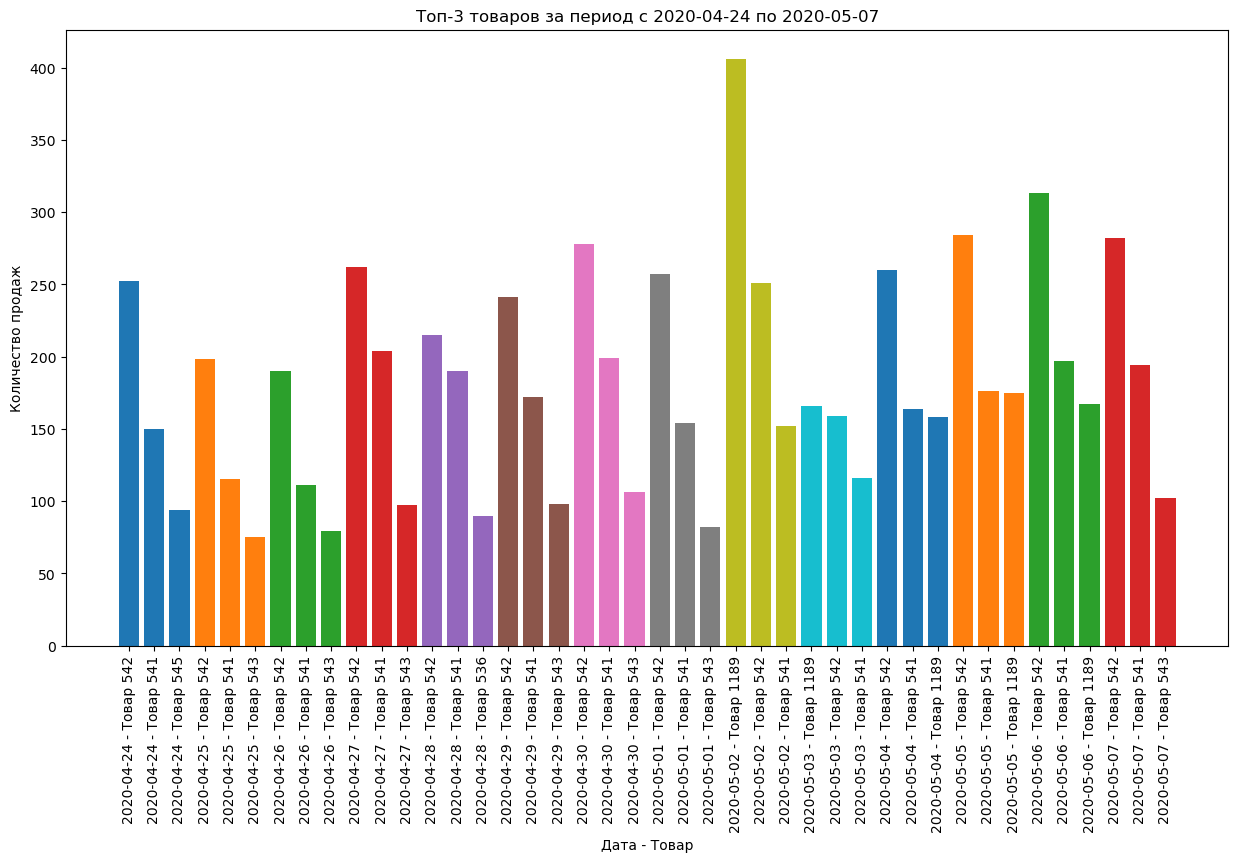

In [17]:
stat_of_the_day(df, 24, 4, 2020, 7, 5, 2020)

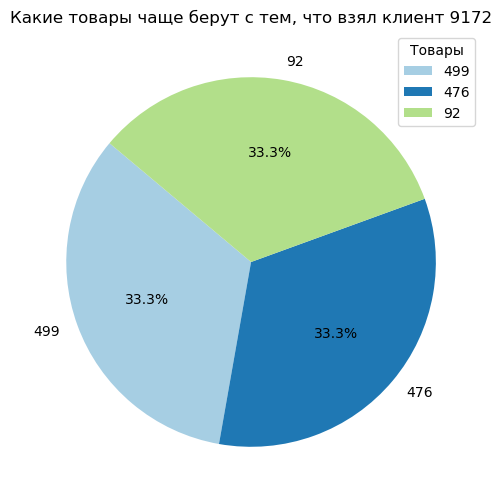

In [18]:
#На какие товары можно дать скидку, при условии что этого товара нет в корзине
most_popular_list, most_popular_df, fig = metrics_client(most_frequent_pairs, 9172, [585]) 

In [19]:
most_popular_list #что рекомендуем взять
most_popular_df #что чаще берут в датафрейме

,second_item,count
49,499,4
50,476,4
51,92,4


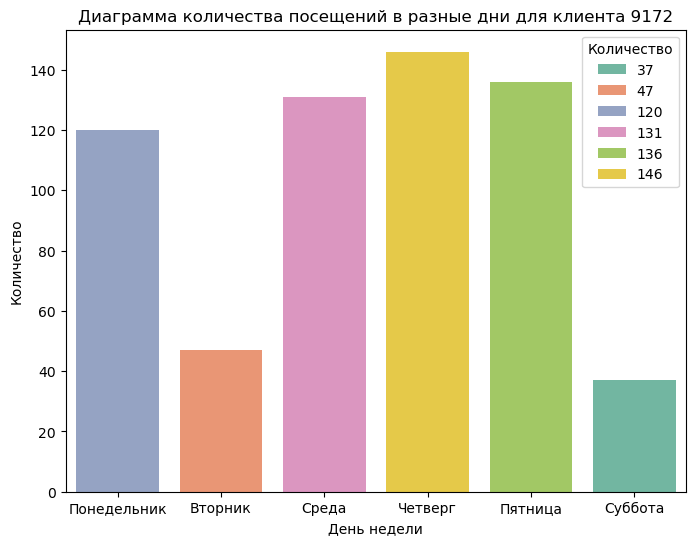

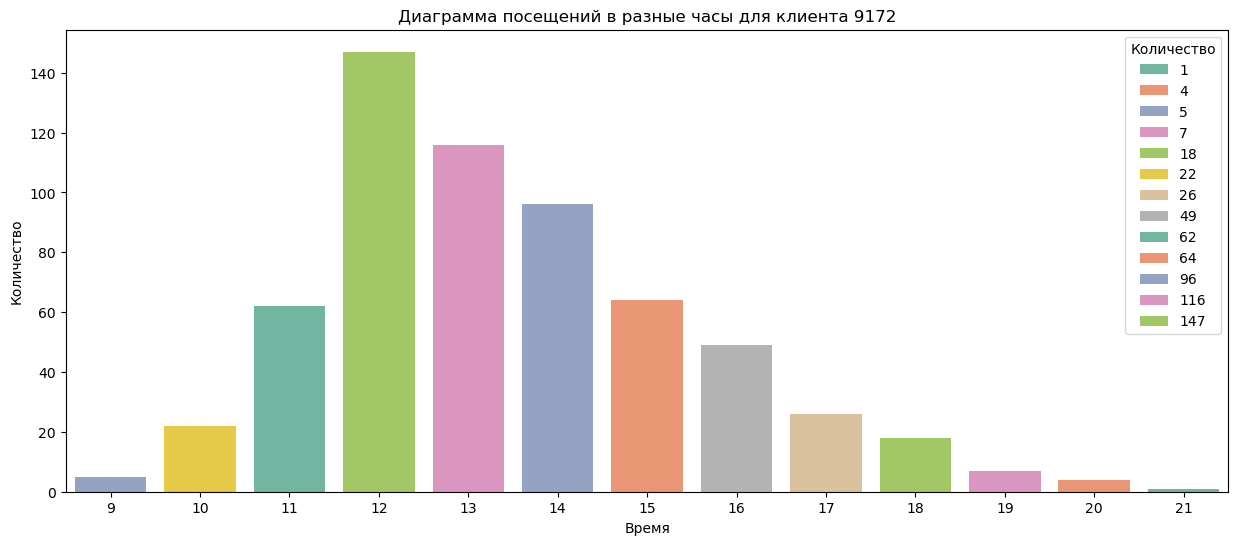

In [20]:
df_visit_frequency = visit_frequency(df, 9172) #В какие дни чаще ходит клиент (без id - в какие дни и часы чаще ходят люди)